# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load Data

In [2]:
# Load the data
data_dir = './WStage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tour_detail = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_reg_compact = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_reg_detail = pd.read_csv(data_dir + 'WRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
df_teams_leagues = pd.merge(left=df_teams, right=pd.read_csv(data_dir + 'WLeagues.csv'), how='left', on=['TeamName'])


### Get Matchups of interest for Training & Test Data

In [3]:
## Get 2018 data

# sorting ensures that we work through smallest to largest 
# no repeats, smallest always first in pair
current_year = df_seeds[df_seeds['Season'] == 2018].sort_values(by=['TeamID'])
current_year_pairs = list(it.combinations(current_year['TeamID'],2))

team1, team2 = map(list, zip(*current_year_pairs))

df_test_pairs = pd.DataFrame({
    'Season' : [2018] * len(team1),
    'Team1' : team1,
    'Team2' : team2
})

In [4]:
# this gives us test pairings! Season, Team1, Team2
df_test_pairs.head()

,Season,Team1,Team2
0,2018,3110,3113
1,2018,3110,3114
2,2018,3110,3124
3,2018,3110,3125
4,2018,3110,3129


In [5]:
# also need previous matchups (1998 - 2017)
df_train_pairs = pd.DataFrame(
    { 'Team1' : df_tour_compact['WTeamID'],
     'Team2' : df_tour_compact['LTeamID'],
     'Season' : df_tour_compact['Season']
    })

df_train_pairs.tail()

,Season,Team1,Team2
1255,2017,3163,3332
1256,2017,3376,3199
1257,2017,3280,3163
1258,2017,3376,3390
1259,2017,3376,3280


In [6]:
# this is what we will use as a base to build our dataset
df_train_test_matchups = df_train_pairs.append(df_test_pairs)

## Feature Engineering for Training & Test Data

### Current Year Seeds

In [7]:
# get just integer value of seed (exclude region information)
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['SeedInt'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [8]:
# merge seeds with team IDs for tourney performance
df_W = df_seeds.rename(columns={'TeamID':'Team1', 'SeedInt':'Team1Seed'})
df_L = df_seeds.rename(columns={'TeamID':'Team2', 'SeedInt':'Team2Seed'})
df_dummy = pd.merge(left=df_train_test_matchups, right=df_W, how='left', on=['Season', 'Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Season', 'Team2'])

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed
3271,2018,3437,3443,9,11
3272,2018,3437,3453,9,7
3273,2018,3438,3443,10,11
3274,2018,3438,3453,10,7
3275,2018,3443,3453,11,7


### Current Year Seed Difference

In [9]:
# negative number indicates that team 2 (loser, in this case) has higher seed
df_matchups['SeedDiff'] = df_matchups['Team2Seed']
df_matchups['SeedDiff'] = df_matchups['Team2Seed'].sub(df_matchups['Team1Seed'], axis=0)

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff
3271,2018,3437,3443,9,11,2
3272,2018,3437,3453,9,7,-2
3273,2018,3438,3443,10,11,1
3274,2018,3438,3453,10,7,-3
3275,2018,3443,3453,11,7,-4


### Last Year's Tournament Seed 

In [10]:
# what to do for games where we had no previous year (1998)?

# add 1 so easily referenced
df_seeds['Season'] = df_seeds['Season'].apply(lambda x: x + 1)

In [11]:
df_W = df_seeds.rename(columns={'TeamID':'Team1','SeedInt':'Team1PrevSeed'})
df_L = df_seeds.rename(columns={'TeamID':'Team2','SeedInt':'Team2PrevSeed'})
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Season', 'Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Season', 'Team2'])

## what to do if they weren't in the tournament last year (17?)
df_matchups = df_matchups.fillna(value=17)

df_matchups.head()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed
0,1998,3104,3422,2,15,13,17.0,17.0
1,1998,3112,3365,3,14,11,17.0,17.0
2,1998,3163,3193,2,15,13,17.0,17.0
3,1998,3198,3266,7,10,3,17.0,17.0
4,1998,3203,3208,10,7,-3,17.0,17.0


### Average Tournament Seed Over Past 5 Years - TODO

### Last Year's Tournament Performance 

### Average Tournament Performance Over Past 5 Years

### League Competitiveness

In [12]:
df_tour_hist = df_matchups
df_tour_hist.head()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed
0,1998,3104,3422,2,15,13,17.0,17.0
1,1998,3112,3365,3,14,11,17.0,17.0
2,1998,3163,3193,2,15,13,17.0,17.0
3,1998,3198,3266,7,10,3,17.0,17.0
4,1998,3203,3208,10,7,-3,17.0,17.0


In [13]:
#
winning_games_w = df_tour_hist.groupby('Team1').count().reset_index()[['Team1','Season']].rename(columns={'Season':'WWins'})
winning_games_l = df_tour_hist.groupby('Team1').count().reset_index()[['Team1','Season']].rename(columns={'Season':'LWins','Team1':'Team2'})

losing_games_w = df_tour_hist.groupby('Team2').count().reset_index()[['Team2','Season']].rename(columns={'Season':'WLosses','Team2':'Team1'})
losing_games_l = df_tour_hist.groupby('Team2').count().reset_index()[['Team2','Season']].rename(columns={'Season':'LLosses'})

# get total tournament games - all games, could be more than 1 appearance per year
df_total_apps = pd.merge(left=df_tour_hist, right=winning_games_w, how='left', on=['Team1']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=winning_games_l, how='left', on=['Team2']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_w, how='left', on=['Team1']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_l, how='left', on=['Team2']).fillna(0)


df_total_apps['WTotGames'] = df_total_apps['WWins'] + df_total_apps['WLosses']
df_total_apps['WPctWins'] = df_total_apps['WWins'] / df_total_apps['WTotGames'] 

df_total_apps['LTotGames'] = df_total_apps['LWins'] + df_total_apps['LLosses']
df_total_apps['LPctWins'] = df_total_apps['LWins'] / df_total_apps['LTotGames'] 

# This now includes: 
df_total_apps.head()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,WWins,LWins,WLosses,LLosses,WTotGames,WPctWins,LTotGames,LPctWins
0,1998,3104,3422,2,15,13,17.0,17.0,3,0.0,2,1,5,0.600000,1.0,0.000000
1,1998,3112,3365,3,14,11,17.0,17.0,5,0.0,6,4,11,0.454545,4.0,0.000000
2,1998,3163,3193,2,15,13,17.0,17.0,147,0.0,19,2,166,0.885542,2.0,0.000000
3,1998,3198,3266,7,10,3,17.0,17.0,2,38.0,3,35,5,0.400000,73.0,0.520548
4,1998,3203,3208,10,7,-3,17.0,17.0,53,70.0,30,38,83,0.638554,108.0,0.648148


In [14]:
# determine 'competitiveness of league' 
## What teams have good win percentages
df_win_apps = df_total_apps.rename(columns={'WPctWins' : 'PctWins','Team1' : 'TeamID', 'WTotGames': 'TotGames'})
df_loss_apps = df_total_apps.rename(columns={'LPctWins' : 'PctWins', 'Team2' : 'TeamID', 'LTotGames': 'TotGames'})

df_apps = df_win_apps[['PctWins','TeamID','TotGames']].append(df_loss_apps[['PctWins','TeamID','TotGames']])
df_apps = df_apps.drop_duplicates()

## This means that a lot of these have never been to the tournament - makes sense
#plt.hist(df_apps['PctWins'],bins=10)

# Maybe need to filter for just teams that are currently in tourney
#l = df_seeds.loc[df_seeds['Season'] == 2018]
#plt.hist((df_apps[df_apps['TeamID'].isin(l['TeamID'])])['PctWins'],bins=10)

In [15]:
df_teams_leagues.head()

,TeamID,TeamName,LeagueName
0,3101,Abilene Chr,Southland
1,3102,Air Force,MWC
2,3103,Akron,MAC
3,3104,Alabama,SEC
4,3105,Alabama A&M,SWAC


In [16]:
# Merge Performance Stats with league info
df_league_pct = pd.merge(left=df_apps, right = df_teams_leagues, how='left', on=['TeamID'])

# group by league to see how leagues perform
df_league_perf = df_league_pct.groupby('LeagueName')['PctWins'].mean().reset_index()

df_league_perf.head()

,LeagueName,PctWins
0,AAC,0.227926
1,ACC,0.501126
2,ASUN,0.172794
3,America East,0.237395
4,Atlantic 10,0.323755


In [17]:
df_teams_leagues = pd.merge(left=df_teams_leagues,right = df_league_perf, how='left', on=['LeagueName'])

In [18]:
df_teams_leagues.head()

,TeamID,TeamName,LeagueName,PctWins
0,3101,Abilene Chr,Southland,0.084656
1,3102,Air Force,MWC,0.299423
2,3103,Akron,MAC,0.231940
3,3104,Alabama,SEC,0.507880
4,3105,Alabama A&M,SWAC,0.090110


In [19]:
df_W = df_teams_leagues[['TeamID','PctWins']].rename(columns={'TeamID':'Team1', 'PctWins' : "Team1LeaguePerf"})
df_L = df_teams_leagues[['TeamID','PctWins']].rename(columns={'TeamID':'Team2', 'PctWins' : "Team2LeaguePerf"})


In [20]:
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Team2'])

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1LeaguePerf,Team2LeaguePerf
3271,2018,3437,3443,9,11,2,17.0,12.0,0.454189,0.282576
3272,2018,3437,3453,9,7,-2,17.0,8.0,0.454189,0.067320
3273,2018,3438,3443,10,11,1,17.0,12.0,0.501126,0.282576
3274,2018,3438,3453,10,7,-3,17.0,8.0,0.501126,0.067320
3275,2018,3443,3453,11,7,-4,12.0,8.0,0.282576,0.067320


In [21]:
df_matchups.head()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1LeaguePerf,Team2LeaguePerf
0,1998,3104,3422,2,15,13,17.0,17.0,0.507880,0.085034
1,1998,3112,3365,3,14,11,17.0,17.0,0.487518,0.165578
2,1998,3163,3193,2,15,13,17.0,17.0,0.227926,0.072917
3,1998,3198,3266,7,10,3,17.0,17.0,0.282576,0.454189
4,1998,3203,3208,10,7,-3,17.0,17.0,0.323755,0.507880


### LAST: Generate negative examples + Split into training (train + dev) and test

In [22]:
## Resolve this!! - for now, drop 1998 because we don't have a previous year
df_matchups = df_matchups[df_matchups['Season'] > 1998]

# test data only
x_test = df_matchups[df_matchups['Season'] == 2018]

In [23]:
# Generate negative examples
df_neg = pd.DataFrame(
{
    'Season' : df_matchups['Season']  ,
    'SeedDiff' : -df_matchups['SeedDiff'],
    'Team1' : df_matchups['Team2']  ,
    'Team1Seed' : df_matchups['Team2Seed']  ,
    'Team1PrevSeed' : df_matchups['Team2PrevSeed']  ,
    'Team1LeaguePerf' : df_matchups['Team2LeaguePerf']  ,
    'Team2' : df_matchups['Team1']  ,
    'Team2Seed' : df_matchups['Team1Seed']  ,
    'Team2PrevSeed' : df_matchups['Team1PrevSeed']  ,
    'Team2LeaguePerf' : df_matchups['Team1LeaguePerf']  ,

})

In [24]:
# include positive and negative examples from 1999 - 2017 (for now)
x_train = df_matchups.append(df_neg)

In [25]:
# build outcome = first 1/2 of data is positive, second 1/2 is negative 
y_train = ([1] * len(df_matchups)) + ([0] * len(df_matchups))

In [26]:
# Split into train and dev
train_x, dev_x, train_y, dev_y = train_test_split(x_train,y_train)

### Build Model

In [27]:
lr = LogisticRegression()

lr.fit(train_x,train_y)
# we achieve 77% accuracy on training data - how does it generalize to dev?
lr.score(train_x,train_y)

0.78128242373936496

In [28]:
lr.score(dev_x,dev_y) # not bad.

0.77162414436838833

In [29]:
lr.coef_

array([[  8.39906932e-06,   4.90979125e-02,  -1.14177720e-02,
         -1.39064273e-01,  -2.38100633e-02,  -2.23135170e-02,
          1.14279819e-02,  -3.65437607e-02,   2.09175006e-02,
          2.67843955e-02]])

## FROM BASELINE SUBMISSION - EDIT/REMOVE THIS

In [30]:
## Fit a logistic regression model through grid search

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(train_x, train_y)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.504, with best C: 0.001


In [47]:
## Make predictions
preds = clf.predict_proba(train_x)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
clipped_preds

array([ 0.66875815,  0.24289617,  0.62112989, ...,  0.11671453,
        0.30187553,  0.61546786])

In [35]:
type(train_x)

pandas.core.frame.DataFrame

In [36]:
pd.X

,0
0,-10
1,-9
2,-8
3,-7
4,-6
5,-5
6,-4
7,-3
8,-2
9,-1


In [43]:
np.arange(-10, 10).reshape(-1, 1)

array([[-10],
       [ -9],
       [ -8],
       [ -7],
       [ -6],
       [ -5],
       [ -4],
       [ -3],
       [ -2],
       [ -1],
       [  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9]])

In [48]:
preds

array([ 0.66875815,  0.24289617,  0.62112989, ...,  0.11671453,
        0.30187553,  0.61546786])

In [52]:
X

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

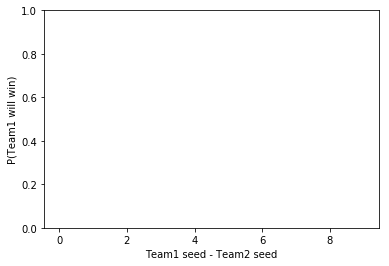

In [53]:
## Plot to confirm intuition that greater positive seed difference indicates higher win probability
X = np.arange(0, 10).reshape(1, -1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')
plt.ylim(0, 1)
plt.show()

In [54]:
df_sample_sub.to_csv('test-submission.csv', index=False)

NameError: name 'df_sample_sub' is not defined

# Evaluation

In [84]:
df_sub = pd.read_csv('WSampleSubmissionStage2.csv')
df_result = pd.read_csv('NCAA_Result_2018.csv')

In [85]:
df_eval = df_result.merge(df_sub, left_on='ID', right_on='ID', how='left')

In [86]:
df_eval

,ID,Result,Pred
0,2018_3163_3384,1,0.5
1,2018_3274_3346,0,0.5
2,2018_3125_3181,0,0.5
3,2018_3208_3273,1,0.5
4,2018_3138_3378,1,0.5
5,2018_3114_3199,0,0.5
6,2018_3143_3438,0,0.5
7,2018_3299_3376,0,0.5
8,2018_3169_3323,0,0.5
9,2018_3355_3437,0,0.5


In [87]:
y_pred = df_eval.loc[:,'Pred'].as_matrix()
y_true = df_eval.loc[:,'Result'].as_matrix()

In [88]:
from sklearn.metrics import log_loss

log_loss(y_true, y_pred, eps=1e-15)

0.69314718055994551